# LDA y detección de topicos

En este script cargaremos un conjunto de mensajes previamente clasficados por Sentiment Analysis con el fin de hacer un análisis de tópicos para los mensajes cuyos sentimientos fueron positivos y otro para los sentimientos negativos. Esta información esta almacena en una base de datos de MongoDB llamada "sentimientos"

In [1]:
#Cargando información de MongoDB
from pymongo import MongoClient

# Create a client instance of MongoClient
client= MongoClient('mongodb://localhost:27017/')
db= client.cultura
collection  = db.sentimientos
# Convertir a Panda
import pandas as pd
data = pd.DataFrame(list(collection.find()))
#Eliminar valores nan de la columna tweet
data['tweet'] = data['tweet'].fillna(' ')

In [2]:
data.head(4)

,_id,polaridad_KNN,polaridad_SVM,tokenizados,tweet,tweets_procesados
0,5d28ea8e98ead074859596ac,-1,-1,"[ahora, mismo, si, tuviese, una, pistola, me, ...",Ahora mismo si tuviese una pistola me pegaba u...,ahor mism si tuv una pistol me peg un tir sin ...
1,5d28ea8e98ead074859596ad,0,1,"[hola, visto, ms, que, visto, ignorado, no, le...",Hola. Visto 05:36. Ms que Visto 05:38. I...,hol vist ms que vist ignor no le import
2,5d28ea8e98ead074859596ae,1,1,"[buenas, noches, a, todos, fav, juju]",Buenas noches a todos... Fav ;) juju,buen noch a tod fav juju
3,5d28ea8e98ead074859596af,-1,1,[jajaja],JAJAJA,jajaj


In [3]:
# Preparacion de la información
polaridad = 'polaridad_SVM' #Variable para definir si vamos a trabajar con la polaridad SVM o KNN
#polaridad = 'polaridad_KNN'
positivos = data.loc[data[polaridad]==1]
positivos = positivos[['tweet','tokenizados',polaridad]]
negativos = data.loc[data[polaridad]==-1]
negativos = negativos[['tweet','tokenizados',polaridad]]

In [4]:
positivos.head(3)

,tweet,tokenizados,polaridad_SVM
1,Hola. Visto 05:36. Ms que Visto 05:38. I...,"[hola, visto, ms, que, visto, ignorado, no, le...",1
2,Buenas noches a todos... Fav ;) juju,"[buenas, noches, a, todos, fav, juju]",1
3,JAJAJA,[jajaja],1


In [5]:
negativos.head(3)

,tweet,tokenizados,polaridad_SVM
0,Ahora mismo si tuviese una pistola me pegaba u...,"[ahora, mismo, si, tuviese, una, pistola, me, ...",-1
5,No va desencaminado!! #MundialBrasil2014 http:...,"[no, va, desencaminado, mundialbrasil, yhdfenzk]",-1
11,Su Mirada &lt;3,"[su, mirada, lt]",-1


In [6]:
#Rango de frecuencias positivas
import nltk
from nltk.corpus import stopwords
import matplotlib as plt
spanish_stopwords = stopwords.words('spanish')


tokenizada = positivos['tokenizados'].get_values()


#Eliminamos las palabras de una y dos letra
for i in range(0,len(tokenizada)):
    tokenizada[i][:]=[w for w in tokenizada[i][:] if (len(w)>2)] #eliminar palabras de una y dos letra
    tokenizada[i][:]=[w for w in tokenizada[i][:] if (w not in spanish_stopwords)] #eliminar stop_words

palabras=[]
#Crear una lista de elemento por palabra
for i in range(0,len(tokenizada)):
    for j in range(0,len(tokenizada[i][:])):
        palabras.append(tokenizada[i][j])

#Calculando frecuencia de las palabras
frecuencia=nltk.FreqDist(palabras)

In [7]:
frecuencia.plot(30,cumulative=False)

<Figure size 640x480 with 1 Axes>

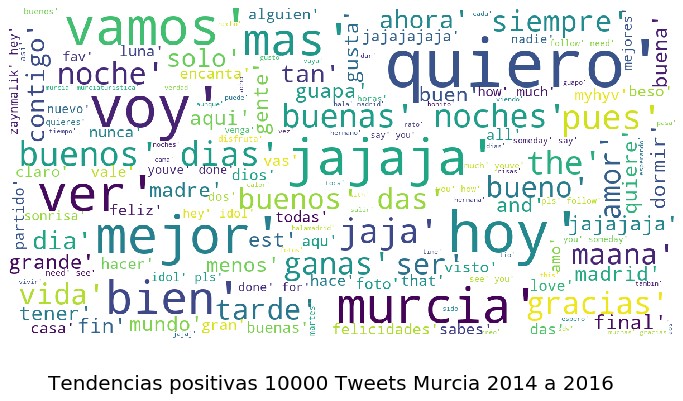

In [8]:
#NUBE DE PALABRAS COMENTARIO POSITIVOS
#https://stackoverrun.com/es/q/4526646
##Creando la nube
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title): 
    wordcloud = WordCloud(
     background_color='white', 
     stopwords=spanish_stopwords, 
     max_words=200, 
     max_font_size=40, 
     scale=3, 
     random_state=1 # chosen at random by flipping a coin; it was heads 
        
    ).generate(str(data)) 

    fig = plt.figure(1, figsize=(12, 12)) 
    plt.axis('off') 
    if title: 
        fig.suptitle(title, fontsize=20) 
        fig.subplots_adjust(top=2.3) 

    plt.imshow(wordcloud) 
    plt.show() 

show_wordcloud(palabras,"Tendencias positivas 10000 Tweets Murcia 2014 a 2016") 

In [9]:
#Rango de frecuencias negativas

tokenizada_neg = negativos['tokenizados'].get_values()

#Eliminamos las palabras de una y dos letra
for i in range(0,len(tokenizada_neg)):
    tokenizada_neg[i][:]=[w for w in tokenizada_neg[i][:] if (len(w)>2)] #eliminar palabras de una y dos letra
    tokenizada_neg[i][:]=[w for w in tokenizada_neg[i][:] if (w not in spanish_stopwords)] #eliminar stop_words

palabras_neg=[]
#Crear una lista de elemento por palabra
for i in range(0,len(tokenizada_neg)):
    for j in range(0,len(tokenizada_neg[i][:])):
        palabras_neg.append(tokenizada_neg[i][j])

#Calculando frecuencia de las palabras
frecuencia_neg=nltk.FreqDist(palabras_neg)

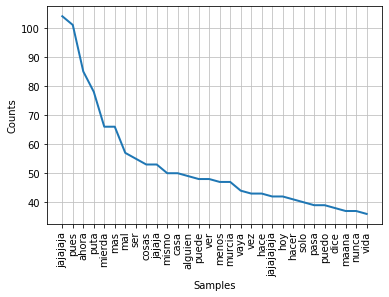

In [10]:
frecuencia_neg.plot(30,cumulative=False)

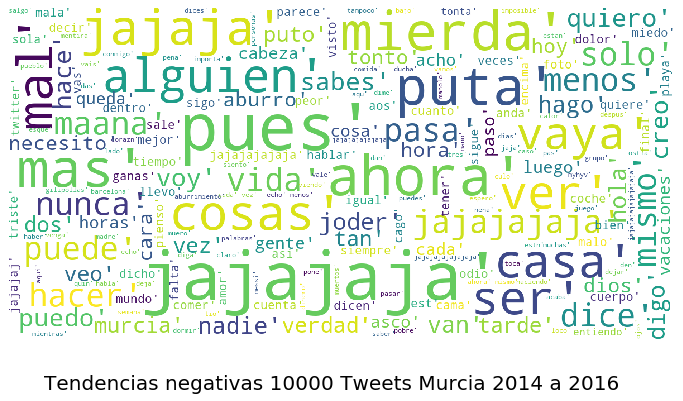

In [11]:
#Nube negativa
show_wordcloud(palabras_neg,"Tendencias negativas 10000 Tweets Murcia 2014 a 2016") 

In [12]:
len(palabras_neg)

16335

In [13]:
#####################################################################
############# LDA Y TOPIC DETECTION FRASES POSITIVAS ################
import gensim
from gensim import corpora,models
import time
start_time = time.time()

doc = positivos['tokenizados'].get_values()
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.tokenizada
#Crear diccionario
dictionary = gensim.corpora.Dictionary(tokenizada)
#Guardar diccionario
dictionary.save('dictionary_pos.dict')
#Calcular corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in (tokenizada)]
#Guardar Corpus
corpora.MmCorpus.serialize('corpus_pos.mm', doc_term_matrix)

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=7, id2word = dictionary, passes=20)
ldamodel.save('topic_pos.model')

#lda_model = gensim.models.LdaMulticore(doc_term_matrix, num_topics=15, id2word=dictionary, passes=12, workers=12)

print("--- %s seconds ---" % (time.time() - start_time))

--- 23.268174171447754 seconds ---


In [14]:
(ldamodel.print_topics(num_topics=7, num_words=14))

[(0,
  '0.028*"you" + 0.011*"the" + 0.010*"for" + 0.009*"follow" + 0.008*"loscoloraos" + 0.008*"need" + 0.008*"much" + 0.008*"how" + 0.008*"see" + 0.008*"pls" + 0.008*"youve" + 0.007*"and" + 0.007*"zaynmalik" + 0.007*"say"'),
 (1,
  '0.032*"murcia" + 0.027*"madrid" + 0.023*"buenas" + 0.016*"noches" + 0.012*"ganas" + 0.012*"procesiones" + 0.011*"hala" + 0.010*"murciaturistica" + 0.007*"partido" + 0.007*"real" + 0.006*"pues" + 0.005*"claro" + 0.005*"jajaja" + 0.004*"dos"'),
 (2,
  '0.016*"gracias" + 0.010*"buena" + 0.008*"final" + 0.008*"guapa" + 0.007*"amor" + 0.007*"tarde" + 0.006*"venga" + 0.006*"ahora" + 0.006*"vaya" + 0.005*"quiero" + 0.005*"jaja" + 0.005*"siempre" + 0.005*"tan" + 0.005*"myhyv"'),
 (3,
  '0.021*"quiero" + 0.021*"buenos" + 0.014*"dias" + 0.013*"halamadrid" + 0.012*"voy" + 0.011*"madrid" + 0.010*"hoy" + 0.009*"das" + 0.009*"catedral" + 0.008*"ver" + 0.008*"bueno" + 0.007*"amo" + 0.006*"siempre" + 0.006*"dios"'),
 (4,
  '0.039*"vamos" + 0.009*"hey" + 0.008*"done" + 0.0

In [15]:
#####################################################################
############# LDA Y TOPIC DETECTION FRASES NEGATIVAS ################

start_time = time.time()

doc = negativos['tokenizados'].get_values()
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.tokenizada
#Crear diccionario
dictionary = gensim.corpora.Dictionary(tokenizada_neg)
#Guardar diccionario
dictionary.save('dictionary_neg.dict')
#Calcular corpus
doc_term_matrix = [dictionary.doc2bow(doc) for doc in (tokenizada_neg)]
#Guardar Corpus
corpora.MmCorpus.serialize('corpus_neg.mm', doc_term_matrix)

Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=7, id2word = dictionary, passes=20)
ldamodel.save('topic_neg.model')

#lda_model = gensim.models.LdaMulticore(doc_term_matrix, num_topics=15, id2word=dictionary, passes=12, workers=12)

print("--- %s seconds ---" % (time.time() - start_time))

--- 17.942914724349976 seconds ---


In [16]:
(ldamodel.print_topics(num_topics=7, num_words=14))

[(0,
  '0.008*"aburro" + 0.008*"hola" + 0.008*"puedo" + 0.006*"mira" + 0.005*"joder" + 0.005*"puede" + 0.005*"ser" + 0.005*"tarde" + 0.005*"tan" + 0.004*"van" + 0.004*"pues" + 0.004*"ver" + 0.004*"decir" + 0.004*"alguien"'),
 (1,
  '0.013*"pues" + 0.008*"nadie" + 0.007*"pasa" + 0.007*"jajaja" + 0.006*"veo" + 0.004*"ser" + 0.004*"paso" + 0.004*"necesito" + 0.004*"cosas" + 0.004*"vez" + 0.004*"nunca" + 0.003*"hablar" + 0.003*"cosa" + 0.003*"amor"'),
 (2,
  '0.014*"ahora" + 0.009*"mismo" + 0.009*"jajajajaja" + 0.008*"casa" + 0.008*"digo" + 0.005*"venga" + 0.004*"dicho" + 0.004*"jaja" + 0.004*"mal" + 0.004*"triste" + 0.004*"jajajaja" + 0.003*"valla" + 0.003*"mierda" + 0.003*"vamos"'),
 (3,
  '0.014*"menos" + 0.008*"echo" + 0.007*"murcia" + 0.006*"cago" + 0.006*"alguien" + 0.005*"quiero" + 0.005*"puta" + 0.004*"myhyv" + 0.004*"barcelona" + 0.004*"cara" + 0.004*"hoy" + 0.004*"queda" + 0.004*"pues" + 0.004*"ahora"'),
 (4,
  '0.021*"jajajaja" + 0.013*"puta" + 0.009*"mierda" + 0.008*"puede" + 0

In [17]:
# Buscar la probabilidad de pertinencia de un cojunto de mensaje de pruebas a los tópicos anteriores
# Primero vamos a buscar la polaridad del mensaje y de acuerdo a eso buscaremos el tópico positivo o negativo

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib
from sklearn import svm

mensaje=["no veo a Colombia con bueno futuro, menos ahora que creo que estamos mal",
      "con tanto mal y odio presente el pais no saldrá adelante",
      "En el año 2050, sueño con un mundo lleno de amor y buenos deseos",
      "quiero un mundo donde prime la vida y el bien"
      
     ]

clf_load = joblib.load('SVM_entrenado_sentimientos_binario.pkl') 

# Cargar vectorizador de entrenamiento
#vectorizer = joblib.load('vectorizado_tres_estados.pkl')
vectorizer = joblib.load('vectorizado_binario.pkl')

# Vectorizar texto
mensajes = vectorizer.transform(mensaje)

#Realizar clasficiacion
polar = clf_load.predict(mensajes)


#Buscar los topicos para los mensajes
#funcion para procesar texto
def pre_new(doc):
    one =doc.lower()
    two =one.split()
    three = dictionary.doc2bow(two)
    return three

for i in range(0,len(polar)):
    if polar[i] == 0:
        negative_topic = gensim.models.ldamodel.LdaModel.load('topic_neg.model')
        seleccion_topico_negativo = negative_topic[(pre_new(mensaje[i]))]
        print("Mensaje No", i+1,":\nProbabilidad de topicos: ",seleccion_topico_negativo)
        maximo= (max([i[1] for i in seleccion_topico_negativo]))
        for i in seleccion_topico_negativo:
            if i[1] == maximo:
                print("Es un mensaje negativo perteneciente al topico:",i[0])
    else:
        positive_topic = gensim.models.ldamodel.LdaModel.load('topic_pos.model')
        seleccion_topico_positivo = positive_topic[(pre_new(mensaje[i]))]
        print("Mensaje No", i+1,":\nProbabilidad de topicos: ",seleccion_topico_positivo)
        maximo= (max([i[1] for i in seleccion_topico_positivo]))
        for i in seleccion_topico_positivo:
            if i[1] == maximo:
                print("Es un mensaje positivo perteneciente al topico:",i[0])

Mensaje No 1 :
Probabilidad de topicos:  [(0, 0.02042815), (1, 0.31984445), (2, 0.020568667), (3, 0.5777247), (4, 0.02046582), (5, 0.020451793), (6, 0.020516396)]
Es un mensaje negativo perteneciente al topico: 3
Mensaje No 2 :
Probabilidad de topicos:  [(0, 0.25590366), (1, 0.20327134), (2, 0.023938129), (3, 0.023911454), (4, 0.02395221), (5, 0.023887869), (6, 0.4451353)]
Es un mensaje negativo perteneciente al topico: 6
Mensaje No 3 :
Probabilidad de topicos:  [(0, 0.22688231), (1, 0.22691332), (2, 0.028815143), (3, 0.22822079), (4, 0.028815035), (5, 0.028815059), (6, 0.23153831)]
Es un mensaje positivo perteneciente al topico: 6
Mensaje No 4 :
Probabilidad de topicos:  [(0, 0.028673602), (1, 0.42718202), (2, 0.2283511), (3, 0.22970241), (4, 0.02867362), (5, 0.02867363), (6, 0.02874366)]
Es un mensaje positivo perteneciente al topico: 1


/opt/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [18]:
# Graficar resultados de los topicos positivos con pydavids
#### Graficando topicos
d = gensim.corpora.Dictionary.load('dictionary_pos.dict')
c = gensim.corpora.MmCorpus('corpus_pos.mm')
lda = gensim.models.LdaModel.load('topic_pos.model')

import pyLDAvis.gensim
#data = pyLDAvis.gensim.prepare(lda, c, d)
#pyLDAvis.display(data)
#pyLDAvis.save_html(data,'grafica_topicos_positivos.html')

In [19]:
#pyLDAvis.display(data)

In [20]:
# Graficar resultados de los topicos negativos con pydavids
#### Graficando topicos
d = gensim.corpora.Dictionary.load('dictionary_neg.dict')
c = gensim.corpora.MmCorpus('corpus_neg.mm')
lda = gensim.models.LdaModel.load('topic_neg.model')

import pyLDAvis.gensim
#data = pyLDAvis.gensim.prepare(lda, c, d)
#pyLDAvis.display(data)
#pyLDAvis.save_html(data,'grafica_topicos_negativos.html')

In [21]:
#pyLDAvis.display(data)